In [1]:
PROJECT_ID = 'dwh-siloam'
REGION = 'asia-southeast1'
print(f"Project ID: {PROJECT_ID}\nRegion: {REGION}")

# Initialize Vertex AI
from pathlib import Path
import vertexai
from google.cloud import aiplatform

print(f"Checking Credentials...")
if not any((Path.cwd()/"service_account").glob('*.json')):
    print("Service account folder is empty. Fallback using default gcloud account")
    aiplatform.init(project=PROJECT_ID, location=REGION)
    vertexai.init(project=PROJECT_ID, location=REGION)
else:
    print('Using service account credentials from service_account folder')
    from google.oauth2 import service_account
    sa_file = list((Path.cwd()/"service_account").glob('*.json'))[0]
    print(f"Using service account file: {sa_file}")
    credentials = service_account.Credentials.from_service_account_file(sa_file)
    aiplatform.init(project=PROJECT_ID, location=REGION, credentials=credentials)
    vertexai.init(project=PROJECT_ID, location=REGION, credentials=credentials)

# Import libraries
from langchain_google_vertexai import VertexAI, ChatVertexAI, create_structured_runnable
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

from typing import List, Optional
import requests

from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import MessagesPlaceholder
from settings import CopilotSettings
import time

Project ID: dwh-siloam
Region: asia-southeast1
Checking Credentials...
Using service account credentials from service_account folder
Using service account file: /Users/donnymirzaadhitama/workspace/others/chatbot-llm/service_account/dwh-siloam-99402e61edd2.json


In [39]:
import os
from pandasai import SmartDataframe, SmartDatalake
import pandas as pd
from pandasai import Agent

In [3]:
PANDASAI_API_KEY = "$2a$10$KwsNJeV.2XVPza4Ca8x9fOyMAhti4IgqBdI0vIfGg7p46b4k2EkrW"
os.environ["PANDASAI_API_KEY"] = PANDASAI_API_KEY

In [63]:
os.environ["LANGCHAIN_API_KEY"] = "ls__0f29968aab6d4fdeac9159bee2e411b1"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "opensource-llm"

from langsmith import Client
client = Client()

## Test using scratch dataframe

In [4]:
df = pd.DataFrame({
    "country": [
        "United States",
        "United Kingdom",
        "France",
        "Germany",
        "Italy",
        "Spain",
        "Canada",
        "Australia",
        "Japan",
        "China",
    ],
    "gdp": [
        19294482071552,
        2891615567872,
        2411255037952,
        3435817336832,
        1745433788416,
        1181205135360,
        1607402389504,
        1490967855104,
        4380756541440,
        14631844184064,
    ],
    "happiness_index": [6.94, 7.16, 6.66, 7.07, 6.38, 6.4, 7.23, 7.22, 5.87, 5.12],
})

df.head()

,country,gdp,happiness_index
0,United States,19294482071552,6.94
1,United Kingdom,2891615567872,7.16
2,France,2411255037952,6.66
3,Germany,3435817336832,7.07
4,Italy,1745433788416,6.38


### Test using default LLM of PandasAI

In [5]:
sdf = SmartDataframe(df)

In [6]:
response = sdf.chat("Negara mana dengan GDP tertinggi? Dan berapa GDP-nya?")
print(response)

Negara dengan GDP tertinggi adalah United States dengan GDP sebesar 19294482071552.


Proof it with pandas querying.

In [9]:
df.loc[df["gdp"] == df["gdp"].max()]

,country,gdp,happiness_index
0,United States,19294482071552,6.94


More test here:

### Test using VertexAI LLM (using csv file dataframe)

In [11]:
config = CopilotSettings()

In [12]:
llm = VertexAI(
    model_name=config.GCP_AGENT_MODEL_NAME, 
    temperature=0, 
    max_output_tokens=8192
)

In [40]:
df_titanic = pd.read_csv("dataset/titanic/train.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
sdf_vertexai = SmartDataframe(
    df_titanic, 
    config={"llm": llm}
)

In [42]:
response = sdf_vertexai.chat("Berapa rata-rata umur penumpang laki-laki yang selamat?")
print(response)

27.276021505376345


Proof it!

In [26]:
df.loc[(df["Sex"] == "male") & (df["Survived"] == 1)]["Age"].mean()

27.276021505376345

### Visualization answer example

'/Users/donnymirzaadhitama/workspace/others/chatbot-llm/exports/charts/temp_chart.png'

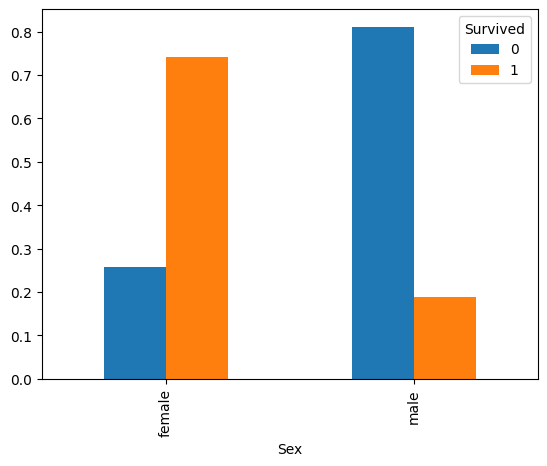

In [28]:
sdf_vertexai.chat("Apakah penumpang laki-laki atau perempuan yang paling banyak selamat?")

More test here:

## Query multiple dataframes using SmartDatalake

In [30]:
employees_data = {
    'EmployeeID': [1, 2, 3, 4, 5],
    'Name': ['John', 'Emma', 'Liam', 'Olivia', 'William'],
    'Department': ['HR', 'Sales', 'IT', 'Marketing', 'Finance']
}

salaries_data = {
    'EmployeeID': [1, 2, 3, 4, 5],
    'Salary': [5000, 6000, 4500, 7000, 5500]
}

employees_df = pd.DataFrame(employees_data)
salaries_df = pd.DataFrame(salaries_data)

In [31]:
employees_df

,EmployeeID,Name,Department
0,1,John,HR
1,2,Emma,Sales
2,3,Liam,IT
3,4,Olivia,Marketing
4,5,William,Finance


In [32]:
salaries_df

,EmployeeID,Salary
0,1,5000
1,2,6000
2,3,4500
3,4,7000
4,5,5500


In [35]:
lake = SmartDatalake(
    [
        employees_df, 
        salaries_df
    ], 
    config={"llm": llm}
)

Departemen dengan gaji tertinggi adalah Marketing dengan gaji rata-rata 7000.0.


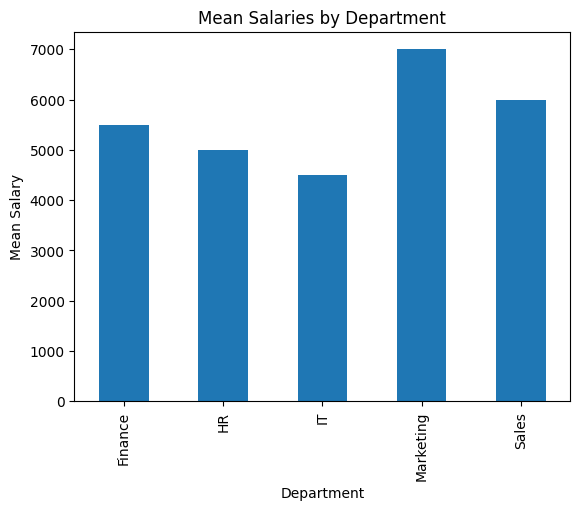

In [38]:
response = lake.chat("Departemen mana yang memiliki gaji tertinggi?")
print(response)

More test here:

## Agent

In [49]:
sales_by_country = pd.DataFrame({
    "country": ["United States", "United Kingdom", "France", "Germany", "Italy", "Spain", "Canada", "Australia", "Japan", "China"],
    "sales": [5000, 3200, 2900, 4100, 2300, 2100, 2500, 2600, 4500, 7000],
    "deals_opened": [142, 80, 70, 90, 60, 50, 40, 30, 110, 120],
    "deals_closed": [120, 70, 60, 80, 50, 40, 30, 20, 100, 110]
})

agent = Agent(
    sales_by_country,
    config={"llm": llm}
)
agent.chat('Which are the top 5 countries by sales?')

680

In [47]:
agent.chat('How about the top opened deals?')

,country,sales,deals_opened,deals_closed
0,United States,5000,142,120
9,China,7000,120,110
8,Japan,4500,110,100
3,Germany,4100,90,80
1,United Kingdom,3200,80,70


Using titanic dataset...

In [64]:
agent = Agent(
    df_titanic,
    config={"llm": llm}
)
response = agent.chat("Berapa rata-rata penumpang laki-laki yang meninggal?")
print(response)

30.72664459161148


In [65]:
explanation = agent.explain()
print(explanation)

 To calculate the average age of male passengers who died, we first need to select only the male passengers from the dataset. We can do this by filtering the dataset based on the 'Sex' column and selecting only the rows where the 'Sex' column is equal to 'male'.

Once we have the male passengers, we can calculate the average age of these passengers by using the 'mean()' function on the 'Age' column.

Finally, we can store the result in a variable and return it as the answer to the query.


In [66]:
print(agent.last_code_executed)

male_passengers = dfs[0][dfs[0]['Sex'] == 'male']
avg_age_male_passengers = male_passengers['Age'].mean()
result = {'type': 'number', 'value': avg_age_male_passengers}


/Users/donnymirzaadhitama/workspace/others/chatbot-llm/exports/charts/temp_chart.png


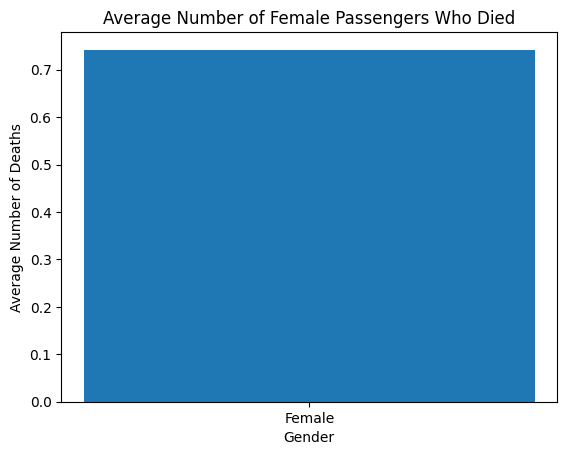

In [60]:
response = agent.chat("Bagaimana dengan penumpang perempuan?")
print(response)

In [61]:
explanation = agent.explain()
print(explanation)

 To calculate the average number of female passengers who died, we first need to filter the DataFrame to only include female passengers. We can do this by using the `[0]` operator to select the first DataFrame in the list of DataFrames, and then using the `['Sex'] == 'female'` operator to select only the rows where the `Sex` column is equal to `female`.

Once we have the DataFrame of female passengers, we can calculate the average number of deaths by using the `mean()` method on the `Survived` column. This will give us the average number of deaths for female passengers.

To display the results, we can use the `plt.bar()` function to create a bar chart. The first argument to `plt.bar()` is the label for the bar, and the second argument is the value of the bar. In this case, the label is `Female` and the value is the average number of deaths for female passengers.

We can then use the `plt.xlabel()` and `plt.ylabel()` functions to label the x-axis and y-axis of the chart, and the `plt.ti

Agent clarification

In [57]:
agent.clarification_questions("Bagaimana dengan penumpang laki-laki?")

['Apakah yang dimaksud dengan penumpang laki-laki adalah penumpang yang berjenis kelamin laki-laki atau penumpang yang meninggal?',
 'Apakah yang dimaksud dengan penumpang laki-laki adalah penumpang yang berjenis kelamin laki-laki atau penumpang yang selamat?',
 'Apakah yang dimaksud dengan penumpang laki-laki adalah penumpang yang berjenis kelamin laki-laki atau penumpang yang memiliki jenis kelamin yang tidak diketahui?']

Rephrase question

In [62]:
rephrased = agent.rephrase_query("Ada berapa penumpang yang")
print(rephrased)

 Ada berapa penumpang yang meninggal?
